# Training the model for the anomaly detection of the CheXpert Dataset

Packages needed are imported.

In [3]:
import numpy as np
import os
import pandas as pd
import PIL
import math as m
import cv2
from sklearn.metrics import roc_curve,roc_auc_score


#Imported by name to ease the creation and training of the models
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

Global variables

In [9]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

DATA = os.path.join(".", "data")
XRAY_SMALL_PATH = os.path.join(DATA, "CheXpert-v1.0-small") #path to the datasets
MODELS = os.path.join(".", "models") #path to the saved models
BASELINE = os.path.join(MODELS, 'bl_model.h5') #path to the saved baseline model
EPOCHS = 10 #Can be higher if early stopping is taken into account, but the epochs are so slow that does not matter
BATCH_SIZE = 32 #Batch size, can be changed
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

Check tensorflow version

In [10]:
print(tf.version.VERSION)

2.1.0


Check if using GPUs.

In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


Training and validation data is loaded.

In [12]:
def load_labels(ray_path=XRAY_SMALL_PATH):
    '''
    Given the path to the datasets returns both training and test csv's.
    Args: 
        ray_path: the path to the datasets.
    Returns: 
        csv_train, csv_val: the csv's part of the CheXpert dataset.
    '''
    
    train_path = os.path.join(ray_path, "train.csv")
    val_path = os.path.join(ray_path, "valid.csv")
    return pd.read_csv(train_path), pd.read_csv(val_path)

csv_train, csv_val = load_labels()

We apply the U-ones policy  and we list the feature columns and classification labels. The U-ones policy is applied (the uncertainty labels get mapped as positive ones), the missing values are preprocessed, and both csv are separated in features and labels.

In [13]:
def prep_train(train, policy):
    '''
    Given the training csv and the policy that will be applied, 
    preprocess the training by applying the policy and filling missing values.
    Args: 
        ray_path: the path to the datasets
    Returns: 
        csv_train, csv_val: the csv's part of the CheXpert dataset.
    '''
    
    if(policy=="u-ones"):
        train = train.replace(to_replace=-1, value=1)
    elif(policy=="u-zeros"):
        train = train.replace(to_replace=-1, value=0)
    
    train["No Finding"].fillna(0, inplace= True)    
    train = train.fillna(-1)
    return train

In [14]:
policy = "u-ones"
csv_train = prep_train(csv_train, policy)

feature = "Path"
labels = ["No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema", "Consolidation", "Pneumonia","Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"]

X_train = csv_train[feature].apply(lambda filename : os.path.join(DATA,filename)).to_numpy()
y_train = csv_train[labels].to_numpy()

X_val = csv_val[feature].apply(lambda filename : os.path.join(DATA,filename)).to_numpy()
y_val = csv_val[labels].to_numpy()

## Data preprocessing.

The filenames are obtained from the *Path* column of the dataset and applied various preprocessing steps.

In [15]:
def parse_function(filename, label):
    """
    Given a path to the image and the label corresponding to that image
    return the image normalized and is label in a tuple.
    Args:
        filename: string representing path to image.
        label: 0/1/-1 one-dimensional array of size N_LABELS.
    Returns:     
        image normalized and its label.
    """
    
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

The dataset is transformed into a tensor of images and labels and divided into batches.

In [16]:
def create_dataset(filenames, labels, is_training=True):
    """
    Load and parse dataset.
    Args:
        filenames: list of image paths.
        labels: numpy array of shape (BATCH_SIZE, N_LABELS).
        is_training: boolean to indicate training mode.
    Returns:
        dataset: a tf.data structure that will be the input tensor for the model.
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    if is_training == True:
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)  
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [17]:
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

The trained model is loaded if there is one. If not, the pretrained model is loaded and various layers are added.

In [18]:
def ignore_binary_crossentropy(y_true, y_pred):
    '''
    Ignore the labels while calculating binary crosentropy if the true value is -1.
    Args:
        y_true: true labels [0/1/-1].
        y_pred: predictions, a probability [0,1].
    Returns:
        binary_crossentropy: the binary crossentropy of the batch.
    '''
        
    y_true = tf.reshape(y_true, [-1]) 
    y_pred = tf.reshape(y_pred, [-1])
    y_true = tf.multiply(y_true, tf.cast(tf.not_equal(y_true, -1), tf.float32))
    y_pred = tf.multiply(y_pred, tf.cast(tf.not_equal(y_true, -1), tf.float32))
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

In [19]:
if os.path.exists(BASELINE):
    model = load_model(BASELINE , custom_objects={'ignore_binary_crossentropy': ignore_binary_crossentropy})
    
else:
    #pretrained = VGG16(include_top=False, input_shape=(224,224,3))
    pretrained = DenseNet121(include_top=False, input_shape=(224,224,3))
    model = tf.keras.Sequential([
        pretrained,
        Flatten(),
        Dense(14, activation = 'sigmoid', name='output')
    ])

    #pretrained.trainable = False


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
output (Dense)               (None, 14)                702478    
Total params: 7,739,982
Trainable params: 7,656,334
Non-trainable params: 83,648
_________________________________________________________________


Callbacks to manage the learning rate every epoch, to save the best model every epoch (according to the validation loss) and to stop the model once the validation loss does not improve.

In [21]:
def scheduler(epoch):
    '''
    Decrease the learning rate by 10 every epoch, starting at 0.0001.
    Args:
        epoch: the epoch in which the model is.
    Returns:
        learning rate
    '''
    
    if epoch<5:
        return 0.001 / 10**(epoch)
    else:
        return 0.001 / 10**5

In [22]:
schedule = LearningRateScheduler(scheduler)
checkpoints = ModelCheckpoint(BASELINE, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

The model is compiled with the **Adam** optimizator, with the predifined values ($\beta _1$=0.9, $\beta _2$=0.999) except the learning rate which will be managed by the scheduler. The loss function is a custom **binary crossentropy**, since the multiple classes must be classified as positive or negative, while ignoring the missing values.

In [23]:
model.compile(optimizer=Adam(), loss=ignore_binary_crossentropy, metrics=["binary_accuracy"])

The model is trained

### Results

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks = [schedule, early_stopping, checkpoints])

The model history with the training and model accuracy:

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The model history with the training and model loss:

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
y_pred_keras = model.predict(val_ds)

In [28]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(csv_val[labels[2]], y_pred_keras[:,2])

In [29]:
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr)
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    

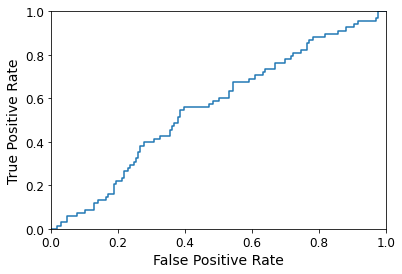

In [30]:
plot_roc_curve(fpr_keras,tpr_keras) 

In [31]:
roc_auc_score(csv_val[labels[2]], y_pred_keras[:,2])

0.5596208362863218